In [1]:
!git clone https://github.com/niazwazir/TestImage.git

Cloning into 'TestImage'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 36 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [0]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=800 height=600></video>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.png', quality=0.8):
  display(HTML(VIDEO_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [3]:
take_photo()

In [0]:
import cv2
img1 = cv2.imread("photo.png")
img_cvt=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [5]:
IMG_SIZE = 500
smallimg1 = cv2.resize(img1,(IMG_SIZE,IMG_SIZE))
img_cvt=cv2.cvtColor(smallimg1, cv2.COLOR_BGR2RGB)
cv2.imwrite("NEWIMAGE.png",img_cvt)

True

In [6]:
from keras.models import Model
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation
from keras.optimizers import adam
from keras.layers.merge import concatenate, add
import numpy
import cv2

def Res_block():
    _input = Input(shape=(None, None, 64))
    conv = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(_input)
    conv = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear')(conv)

    out = add(inputs=[_input, conv])
    out = Activation('relu')(out)

    model = Model(inputs=_input, outputs=out)

    return model



def model_WAZIR():
    _input = Input(shape=(None, None, 1), name='input')

    Feature = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(_input)
    Feature_out = Res_block()(Feature)

    #Upsampling
    Upsampling1 = Conv2D(filters=4, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Feature_out)
    Upsampling2 = Conv2DTranspose(filters=4, kernel_size=(18,18), strides=(8,8),
                                  padding='same', activation='relu')(Upsampling1)

                           
    Upsampling3 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Upsampling2)

    

    # Mulyi-scale Reconstruction
    Reslayer1 = Res_block()(Upsampling3)

    Reslayer2 = Res_block()(Reslayer1)

    
     # ***************//
    Multi_scale1 = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Reslayer2)

    Multi_scale2a = Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)

    Multi_scale2b = Conv2D(filters=16, kernel_size=(1, 3), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2b = Conv2D(filters=16, kernel_size=(3, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2b)

    Multi_scale2c = Conv2D(filters=16, kernel_size=(1, 3), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2c = Conv2D(filters=16, kernel_size=(3, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2c)

    Multi_scale2d = Conv2D(filters=16, kernel_size=(1, 7), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale1)
    Multi_scale2d = Conv2D(filters=16, kernel_size=(7, 1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2d)

    Multi_scale2e = Conv2D(filters=16, kernel_size=(1,7), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2d)

    Multi_scale2f = Conv2D(filters=16, kernel_size=(7,1), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2e)

    Multi_scale2g = Conv2D(filters=16, kernel_size=(1,9), strides=(1, 1),
                           padding='same', activation='relu')(Multi_scale2f)
    
    Multi_scale2 = concatenate(inputs=[Multi_scale2a, Multi_scale2b, Multi_scale2c, Multi_scale2d,Multi_scale2e, Multi_scale2f, Multi_scale2g])

    out = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(Multi_scale2)
    model = Model(input=_input, output=out)

    return model


def WAZIR_train():
    WAZIR = model_WAZIR()
    WAZIR.compile(optimizer=adam(lr=0.0003), loss='mse')
    #WAZIR.summary()
    #data, label = pd.read_training_data("traininingscale8.h5")
    #WAZIR.fit(data, label, batch_size=128, epochs=8)##############################
    #WAZIR.save_weights("WAZIR_MODEL_SCALE_8.h5")


def WAZIR_predict():
    WAZIR = model_WAZIR()
    WAZIR.load_weights("TestImage/WAZIR_MODEL_SCALE_8.h5")
    IMG_NAME = "photo.png"
    #IMG_NAME = "DATASETS/SET14/lenna.bmp"
    #IMG_NAME = "DATASETS/URBAN100/img042.png"
    #IMG_NAME = "DATASETS/MANGA109/A.png"
    #IMG_NAME = "DATASETS/ABC/HR.png"
    
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.png"
    OUTPUT_NAME = "OUT_HIGH_RESOLUTION_IMAGE.png"

    
    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // 8, shape[0] // 8), cv2.INTER_CUBIC)
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    
    pre = WAZIR.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)
    im2 = cv2.resize(im2, (img.shape[1], img.shape[0]))
    im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)

  
    print ("WAZIR_MODEL:")
    print (cv2.PSNR(im1, im3))

    
    
if __name__ == "__main__":
    WAZIR_train()
    WAZIR_predict()


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`




WAZIR_MODEL:
41.267474664506956


In [0]:
from google.colab.patches import cv2_imshow

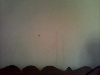

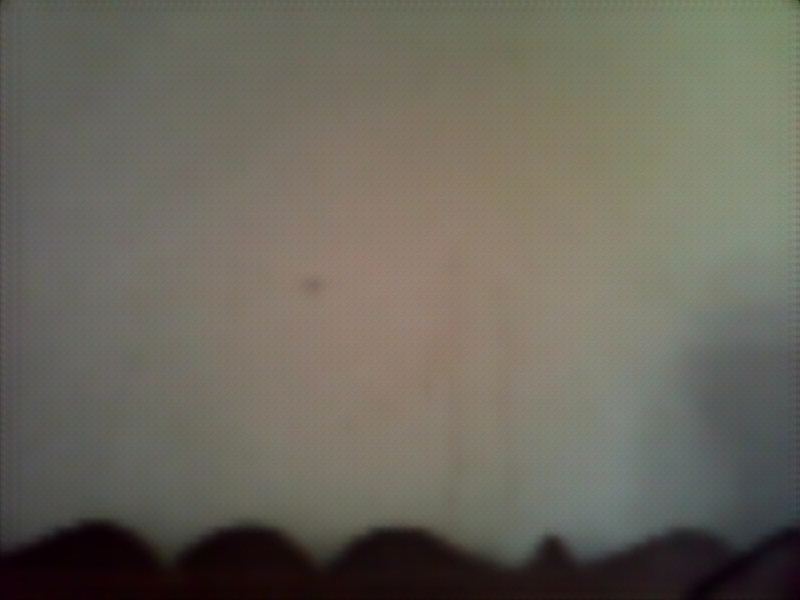

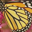

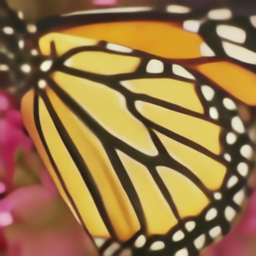

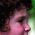

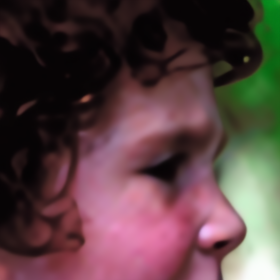

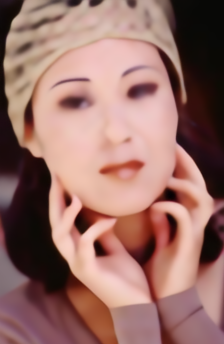

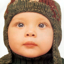

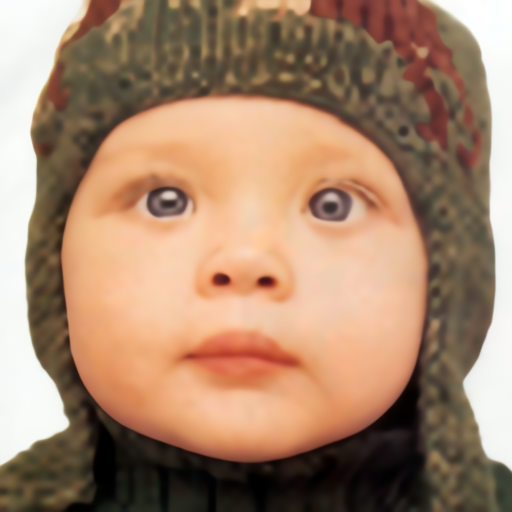

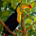

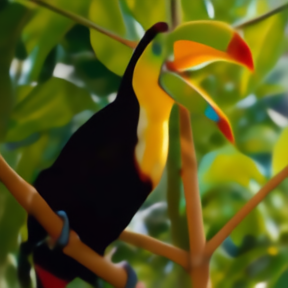

In [8]:
img = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('OUT_HIGH_RESOLUTION_IMAGE.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

img = cv2.imread('TestImage/butterfly8LR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('TestImage/butterfly8HR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

img = cv2.imread('TestImage/head8LR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('TestImage/head8HR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

img = cv2.imread('TestImage/woman8LR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('TestImage/woman8HR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)


img = cv2.imread('TestImage/baby8LR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('TestImage/baby8HR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

img = cv2.imread('TestImage/bird8LR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread('TestImage/bird8HR.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

